In [1]:
COLAB = False
# On Windows Run in ENSC_413 Folder

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle competitions download -c birdclef-2022 -p /content/

100% 6.11G/6.12G [02:28<00:00, 55.5MB/s]
100% 6.12G/6.12G [02:28<00:00, 44.2MB/s]


In [6]:
! mkdir /content/birdclef-2022
! unzip /content/birdclef-2022.zip -d /content/drive/MyDrive/birdclef-2022

Archive:  /content/birdclef-2022.zip
replace /content/drive/MyDrive/birdclef-2022/eBird_Taxonomy_v2021.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/drive/MyDrive/birdclef-2022/eBird_Taxonomy_v2021.csv  
replace /content/drive/MyDrive/birdclef-2022/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/drive/MyDrive/birdclef-2022/sample_submission.csv  
replace /content/drive/MyDrive/birdclef-2022/scored_birds.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [14]:
from tensorflow import keras
# force a channel ordering
from keras import backend

import numpy as np
import librosa as lb
import librosa.display as lbd
from pathlib import Path
from matplotlib import pyplot as plt
import pandas as pd

import mimetypes
mimetypes.init()
mimetypes.add_type('audio/ogg','.ogg')
import IPython.display as ipd

from sklearn.preprocessing import LabelEncoder

Enter the Path:

In [3]:
if COLAB:
    DATA_ROOT = Path("/content/drive/MyDrive/birdclef-2022")
    TRAIN_AUDIO_ROOT = Path("/content/drive/MyDrive/birdclef-2022/train_audio")
    NO_CALL_ROOT = Path("/content/drive/MyDrive/no_call_detect")
    TRAIN_AUDIO_IMAGES_SAVE_ROOT = Path("/content/drive/MyDrive/audio_images") # Where to save the mels images

    MODEL_SAVE_ROOT = Path("/content/drive/MyDrive/model_save")
    MODEL_SAVE_NAME = 'Local-ResNet50V2_model.h5'
else:
    DATA_ROOT = Path(r"C:\Users\xuewi\Desktop\SFU\ENSC_413\BirdCLEF2022-Project\kaggle\input\birdclef-2022")
    TRAIN_AUDIO_ROOT = Path(r"C:\Users\xuewi\Desktop\SFU\ENSC_413\BirdCLEF2022-Project\kaggle\input\birdclef-2022\train_audio")
    NO_CALL_ROOT = Path(r"C:\Users\xuewi\Desktop\SFU\ENSC_413\BirdCLEF2022-Project\no_call_detect")

     # TRAIN_AUDIO_IMAGES_SAVE_ROOT = Path("/content/drive/MyDrive/audio_images")
    TRAIN_AUDIO_IMAGES_SAVE_ROOT = Path(r"C:\Users\xuewi\Desktop\SFU\ENSC_413\audio_images")

    MODEL_SAVE_ROOT = Path(r"C:\Users\xuewi\Desktop\SFU\ENSC_413\BirdCLEF2022-Project\model_save")
    MODEL_SAVE_NAME = 'Local-ResNet50V2_model.h5'


In [4]:
import json
f = open(DATA_ROOT/"scored_birds.json")
data = json.load(f)
print(data)

['akiapo', 'aniani', 'apapan', 'barpet', 'crehon', 'elepai', 'ercfra', 'hawama', 'hawcre', 'hawgoo', 'hawhaw', 'hawpet1', 'houfin', 'iiwi', 'jabwar', 'maupar', 'omao', 'puaioh', 'skylar', 'warwhe1', 'yefcan']


In [5]:
# force channels-first ordering
#backend.set_image_data_format('channels_first')
#print(backend.image_data_format())

#backend.set_image_data_format('channels_last')
#print(backend.image_data_format())

model = keras.models.load_model(MODEL_SAVE_ROOT/MODEL_SAVE_NAME)

Enter the Audio File

In [100]:
file_no = 0
byFileNo = True
byFilePath = False
byRandom = False

In [115]:
df = pd.read_csv(NO_CALL_ROOT/"nocalldetection_for_shortaudio_fold0.csv")

if byRandom:
    file_path = df.sample().iloc[0]['filename']
    file_name = file_path.split('/')[1]
    primary_label = file_path.split('/')[0]
elif byFilePath:
    file_path = "akekee/XC174954.ogg"
    file_name = file_path.split('/')[1]
    primary_label = file_path.split('/')[0]
elif byFileNo:
    print(file_no)
    primary_label = "barpet"
    # amewig/XC384955.ogg
    temp_rows = df.loc[df['primary_label'].str.match(primary_label)]
    file_path = temp_rows.iloc[file_no]['filename']
    file_name = file_path.split('/')[1]
    file_no = file_no + 1
else:
    primary_label = "amewig"
    file_name = 'XC593011.ogg'
    file_path = primary_label + '/' + file_name

print(file_path)
print(file_name)

2
barpet/XC295060.ogg
XC295060.ogg


In [116]:
no_call_prob = df.loc[df['filename'].str.match(file_path)]
temp_str = no_call_prob.iloc[0]['nocalldetection']

call_prob = [float(x) for x in temp_str.split()]
print(call_prob)

[0.24369660019874573, 0.6201604604721069, 0.43020379543304443, 0.43263354897499084, 0.6221542954444885, 0.6824531555175781, 0.6043869256973267, 0.6451190114021301, 0.7714815735816956, 0.7652182579040527, 0.7502058148384094, 0.5939019918441772, 0.6660374402999878, 0.7998173832893372, 0.42489850521087646, 0.2120511680841446, 0.6012769937515259, 0.2549264430999756, 0.06144951656460762, 0.600654125213623, 0.3774682283401489, 0.6746239066123962, 0.24260564148426056, 0.4767182171344757, 0.6653860807418823, 0.46211227774620056, 0.29418841004371643, 0.31147417426109314, 0.5157557129859924, 0.4445393681526184, 0.6628651022911072, 0.07849214971065521, 0.45980826020240784, 0.6799061894416809, 0.4699757397174835, 0.15475784242153168, 0.14198745787143707, 0.11017788201570511, 0.16798976063728333, 0.5191290378570557, 0.37365004420280457]


In [117]:
print(str( (TRAIN_AUDIO_IMAGES_SAVE_ROOT/primary_label/file_name).as_posix() + ".npy"))
mels = np.load( str( (TRAIN_AUDIO_IMAGES_SAVE_ROOT/primary_label/file_name).as_posix() + ".npy") )

print(mels.shape)

C:/Users/xuewi/Desktop/SFU/ENSC_413/audio_images/barpet/XC295060.ogg.npy
(41, 128, 281)


Listen to Audio and View the Mel

In [118]:
def normalize(image):
        image = image.astype("float32", copy=False) / 255.0
        image = np.stack([image, image, image])
        image = np.stack([image])
        return image

In [119]:
ipd.display(ipd.Audio(str(TRAIN_AUDIO_ROOT/primary_label/file_name)))

In [120]:
le = LabelEncoder()
le.classes_ = np.load(MODEL_SAVE_ROOT/"classes.npy")

def predict(image):
    im = normalize(image)
    predictions = model.predict(im)[0]
    #print(predictions)
    bird_idx = sorted(range(len(predictions)), key=lambda i: predictions[i])[-5:]
    print(bird_idx)
    bird_name = le.inverse_transform(bird_idx)
    le_name_mapping = dict(zip(le.classes_.astype(str), le.transform(le.classes_)))
    #print(le_name_mapping)
    print(bird_name)
    bird_pred = []
    for i in range(len(bird_idx)):
        bird_pred.append({bird_name[i], predictions[bird_idx[i]]})
    print(bird_pred)
    return bird_pred



    

[87, 119, 53, 94, 9]
['mallar3' 'rettro' 'gnwtea' 'no_call' 'barpet']
[{0.0015821106, 'mallar3'}, {'rettro', 0.0052941865}, {0.010875155, 'gnwtea'}, {0.22222592, 'no_call'}, {0.7334251, 'barpet'}]
[119, 55, 53, 94, 9]
['rettro' 'grbher3' 'gnwtea' 'no_call' 'barpet']
[{'rettro', 0.008663453}, {0.010102118, 'grbher3'}, {0.038011543, 'gnwtea'}, {0.2367318, 'no_call'}, {0.6620464, 'barpet'}]
[18, 87, 53, 9, 94]
['brant' 'mallar3' 'gnwtea' 'barpet' 'no_call']
[{0.002804433, 'brant'}, {0.004612135, 'mallar3'}, {0.0050063794, 'gnwtea'}, {0.05853991, 'barpet'}, {0.9111372, 'no_call'}]
[48, 32, 13, 9, 94]
['eurwig' 'caster1' 'bknsti' 'barpet' 'no_call']
[{0.0019557648, 'eurwig'}, {0.0022485526, 'caster1'}, {'bknsti', 0.005945479}, {0.23492774, 'barpet'}, {0.74065334, 'no_call'}]
[55, 130, 119, 94, 9]
['grbher3' 'sheowl' 'rettro' 'no_call' 'barpet']
[{0.030037161, 'grbher3'}, {0.04072605, 'sheowl'}, {'rettro', 0.048048858}, {0.25570473, 'no_call'}, {0.403333, 'barpet'}]
[87, 50, 53, 94, 9]
['mal

C:\Users\xuewi\anaconda3\envs\ensc813-s2022\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


[146, 30, 9, 87, 94]
['whfibi' 'cangoo' 'barpet' 'mallar3' 'no_call']
[{0.023966655, 'whfibi'}, {0.03192361, 'cangoo'}, {0.0473454, 'barpet'}, {0.07649213, 'mallar3'}, {0.64901614, 'no_call'}]
[87, 146, 10, 94, 55]
['mallar3' 'whfibi' 'bcnher' 'no_call' 'grbher3']
[{0.0121136755, 'mallar3'}, {0.028090965, 'whfibi'}, {0.036888383, 'bcnher'}, {0.11199099, 'no_call'}, {0.7643556, 'grbher3'}]
[30, 146, 55, 10, 94]
['cangoo' 'whfibi' 'grbher3' 'bcnher' 'no_call']
[{0.037881035, 'cangoo'}, {0.043809757, 'whfibi'}, {0.06695411, 'grbher3'}, {0.17627287, 'bcnher'}, {0.56898487, 'no_call'}]
[9, 21, 10, 55, 94]
['barpet' 'brnowl' 'bcnher' 'grbher3' 'no_call']
[{0.0016497136, 'barpet'}, {0.0017733545, 'brnowl'}, {0.0018755766, 'bcnher'}, {0.0033863063, 'grbher3'}, {0.9875996, 'no_call'}]
[10, 55, 50, 87, 94]
['bcnher' 'grbher3' 'gadwal' 'mallar3' 'no_call']
[{0.0020977792, 'bcnher'}, {0.0021259976, 'grbher3'}, {0.004649936, 'gadwal'}, {0.004749072, 'mallar3'}, {0.9766401, 'no_call'}]
[21, 87, 55, 

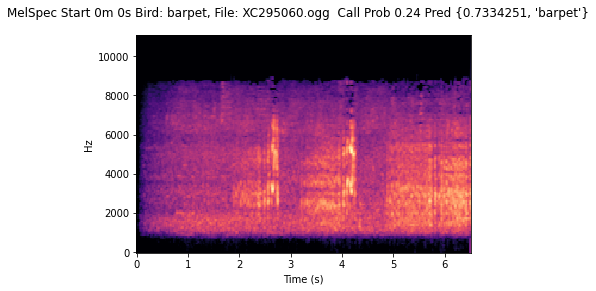

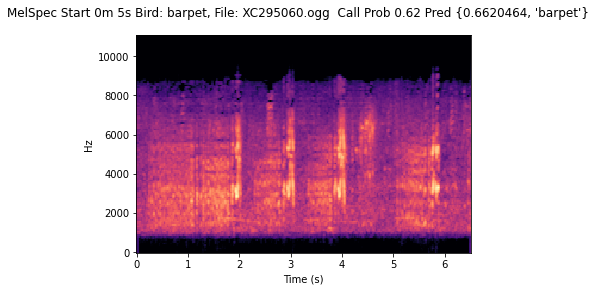

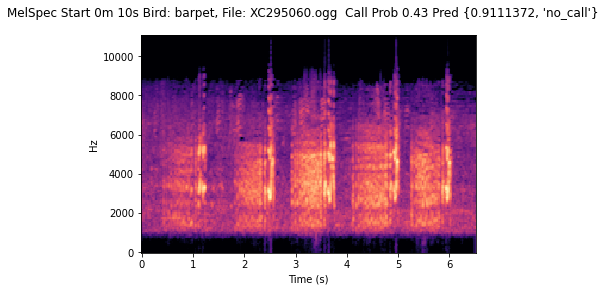

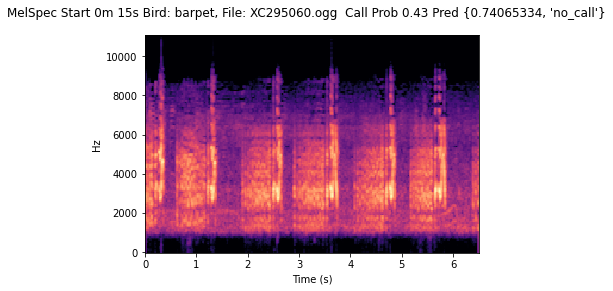

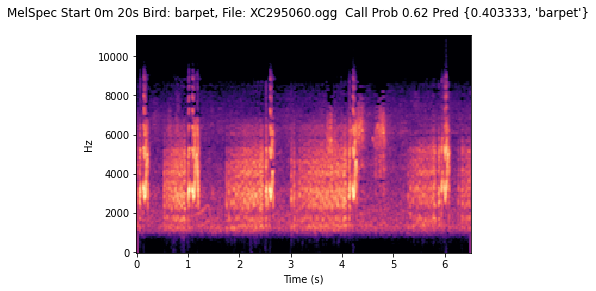

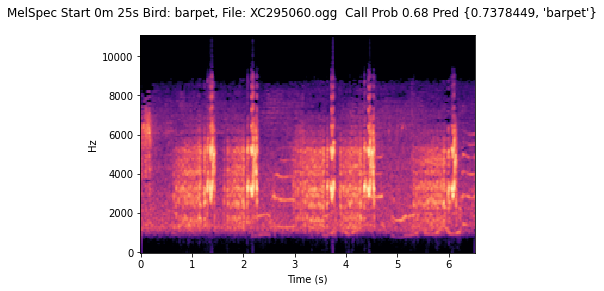

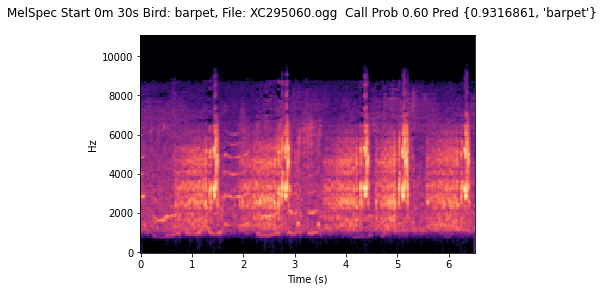

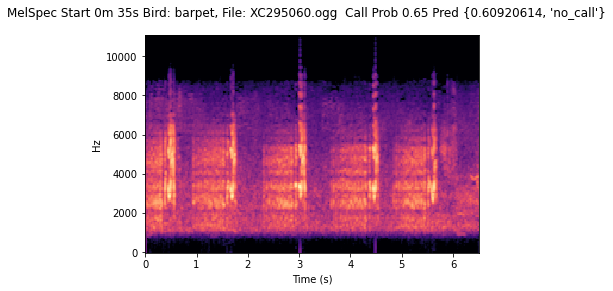

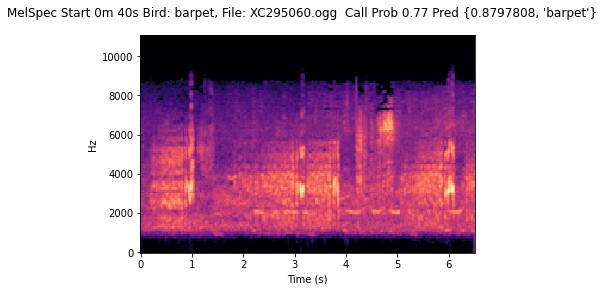

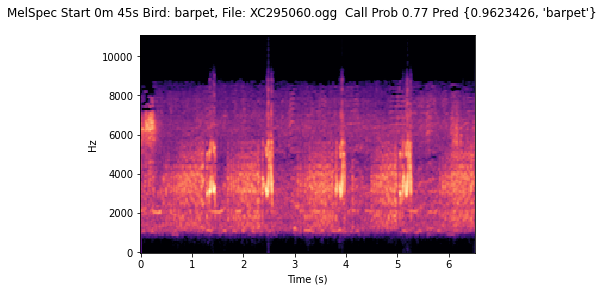

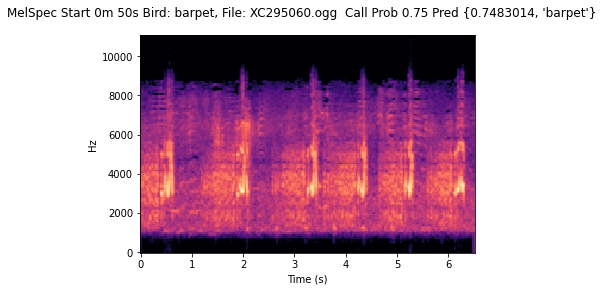

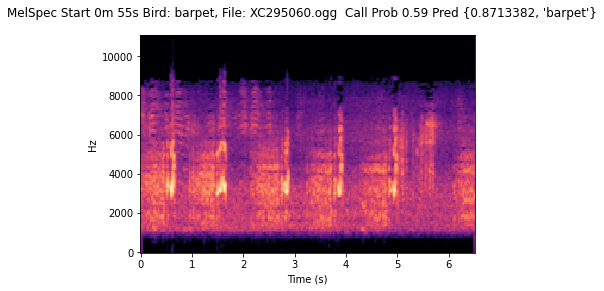

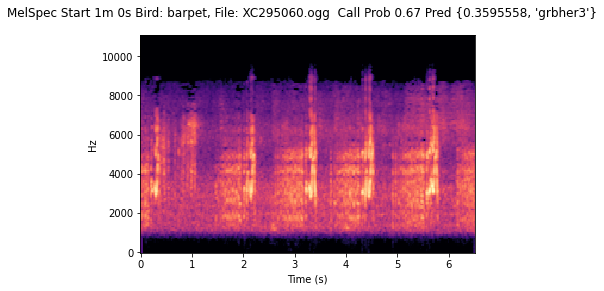

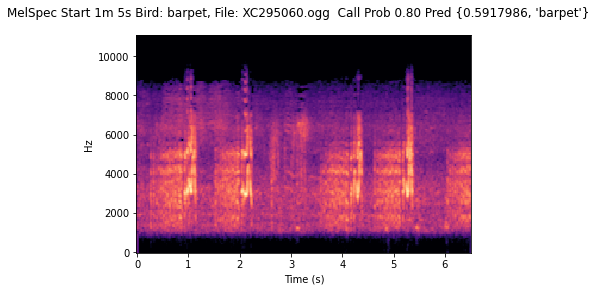

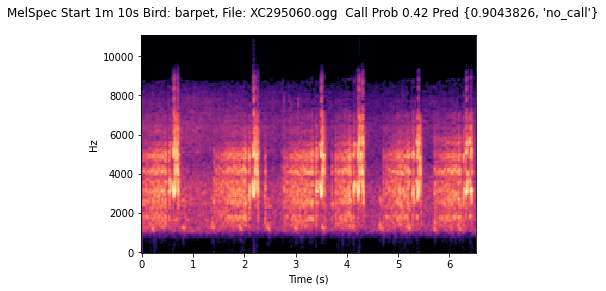

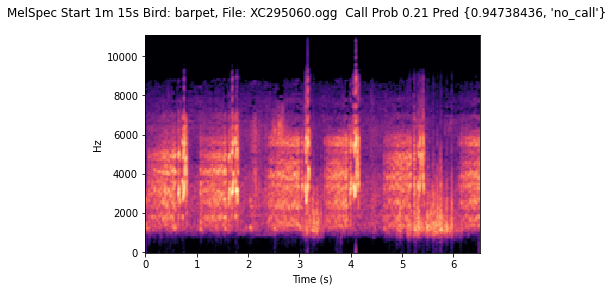

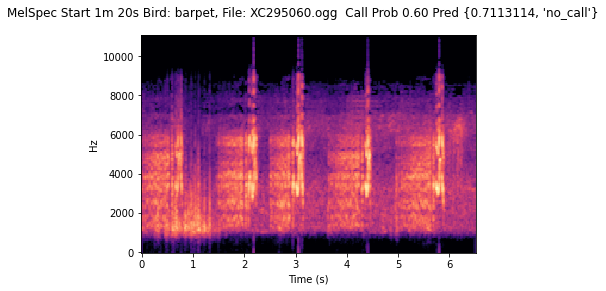

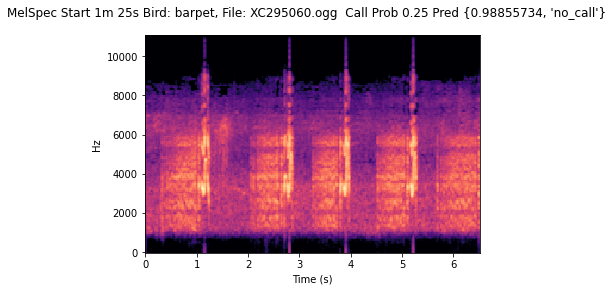

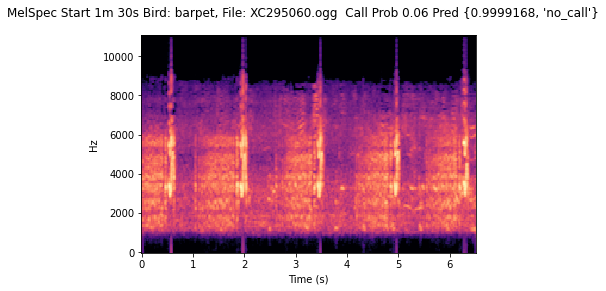

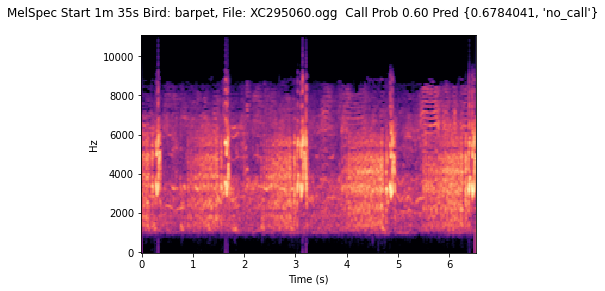

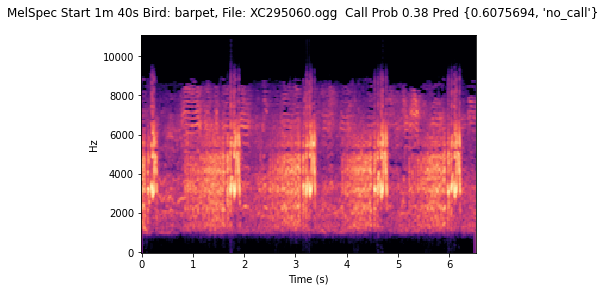

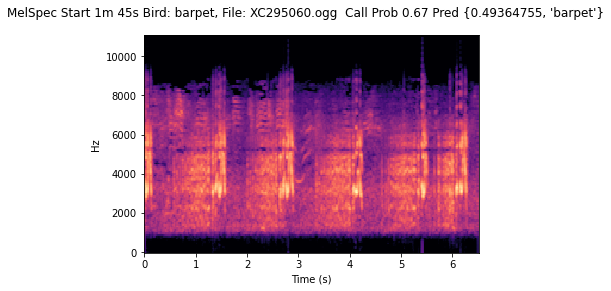

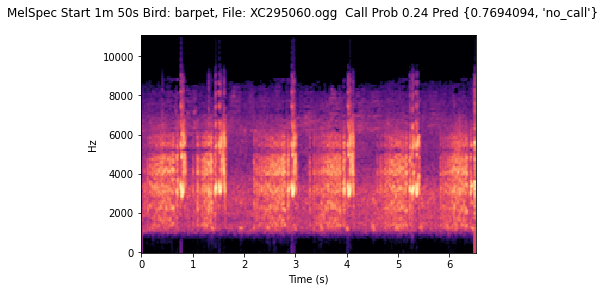

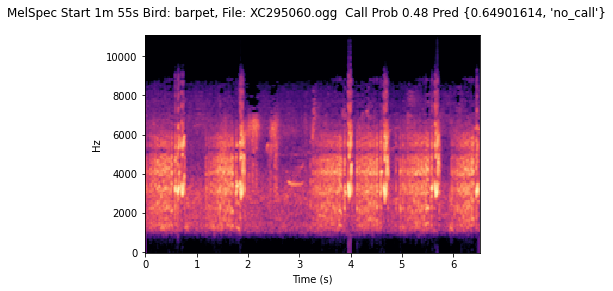

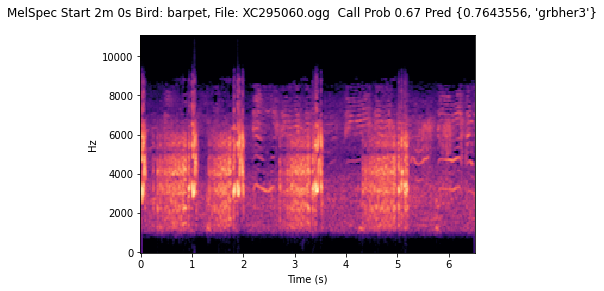

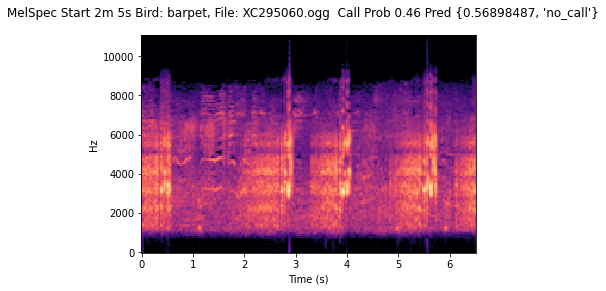

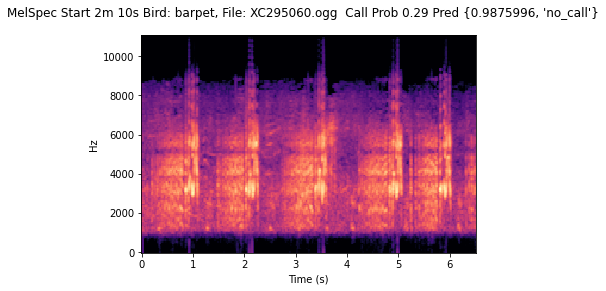

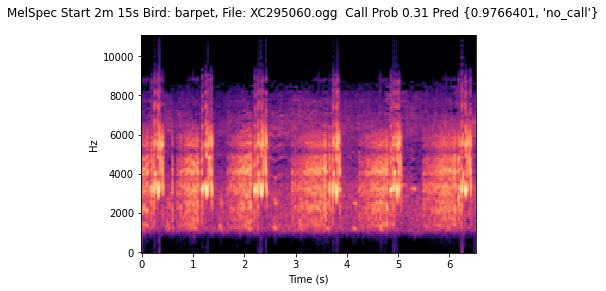

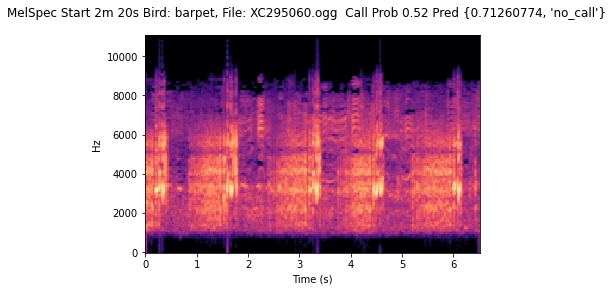

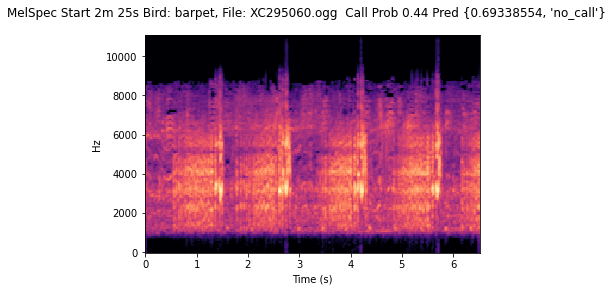

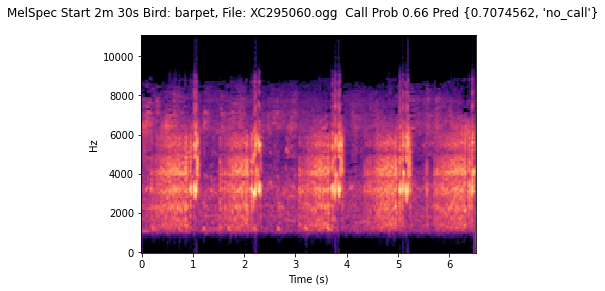

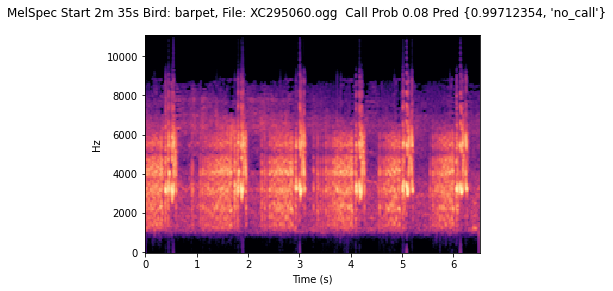

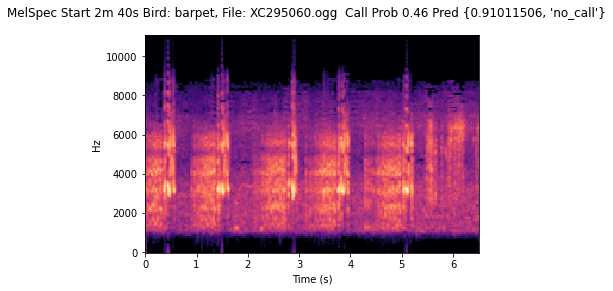

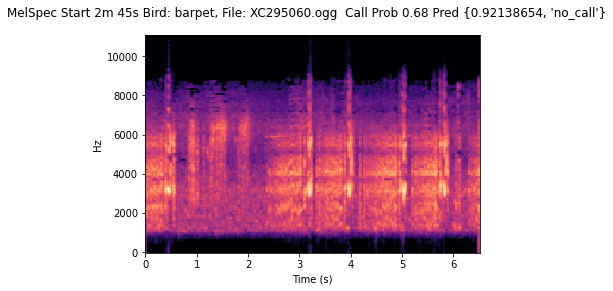

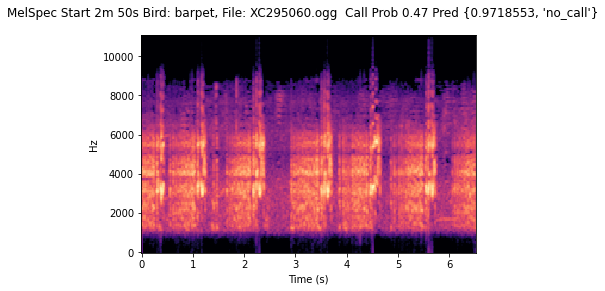

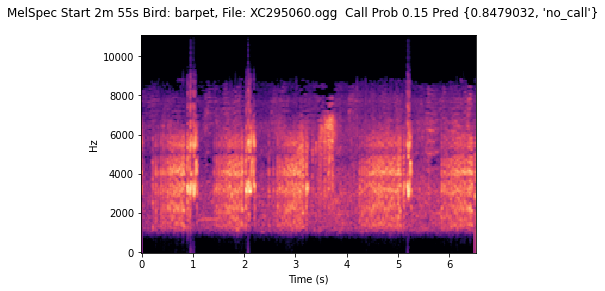

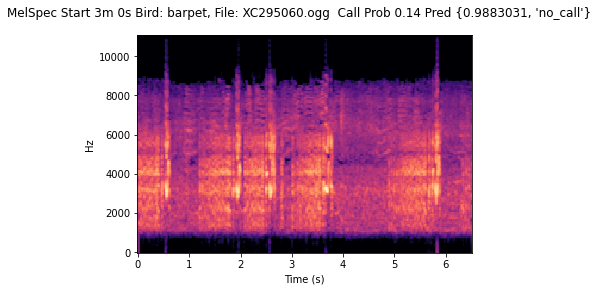

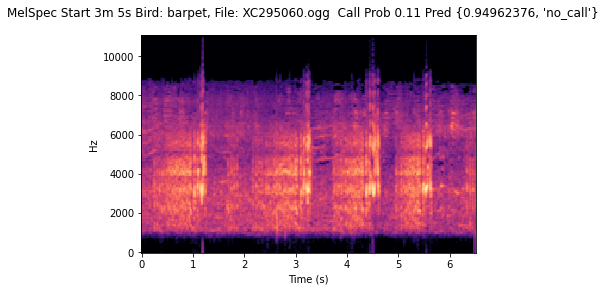

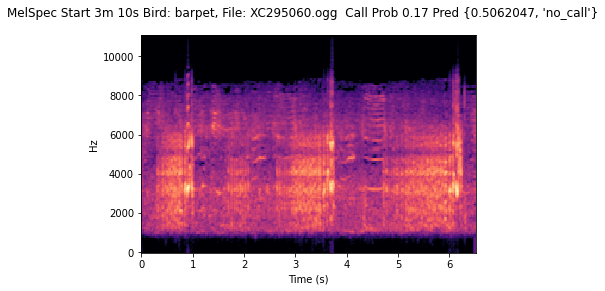

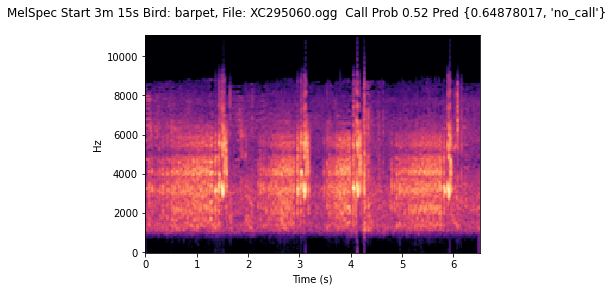

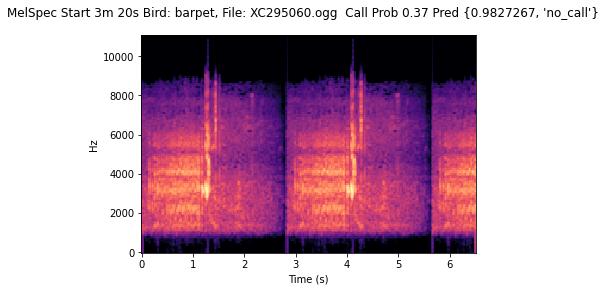

In [121]:
%matplotlib inline 
ipd.display(ipd.Audio(str(TRAIN_AUDIO_ROOT/primary_label/file_name)))
for i in range(len(mels)):
  
  predictions = predict(mels[i])
  fig = plt.figure()
  fig.suptitle(f"MelSpec Start {i*5//60}m {i*5%60}s Bird: {primary_label}, File: {file_name}  Call Prob {call_prob[i]:.2f} Pred {predictions[-1]}")
  lbd.specshow(mels[i], x_axis='s', y_axis='hz')
  #ipd.display(ipd.Audio(str(TRAIN_AUDIO_ROOT/primary_label/file_name)))
